* A concise end-to-end demo of retail sales forecasting using Python and scikit-learn. Demonstrates time-based feature engineering, model comparison (Linear Regression, Neural Network), and iterative forecasting for future periods. Designed as a lightweight, interpretable template for real-world demand prediction tasks.

In [2]:
# Load all necessary Python libraries
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt

* Step-1: Load raw sales data:
    * Load raw csv file
    * Overview of the data structures, columns, rows
    * A quick plot of the data (x-axis in month and y-axis in sales

   month      sales
0    1.0  24.321676
1    2.0  29.212176
2    3.0  33.632435
3    4.0  27.904117
4    5.0  31.633817
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   month   100 non-null    float64
 1   sales   98 non-null     float64
dtypes: float64(2)
memory usage: 1.7 KB
None


Text(0.5, 1.0, 'Raw Data: Sales Prediction.csv')

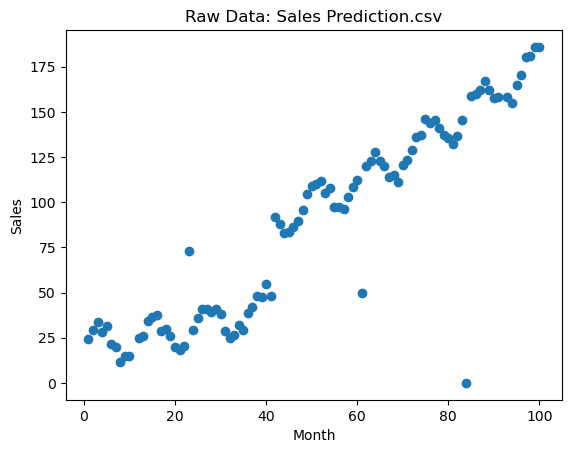

In [12]:
# 1. Load raw sales data from ABC store
df = pd.read_csv("data/Sales Prediction.csv")

# Standardize column names
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Drop rows where BOTH month and sales are NaN
df = df.dropna(subset=["month", "sales"], how="all").reset_index(drop=True)

# # ---------- remove obvious outliers ----------
# # 1) remove zero or negative sales
# df = df[df["sales"] > 0].copy()

# # 2) remove statistical outliers using IQR
# q1 = df["sales"].quantile(0.25)
# q3 = df["sales"].quantile(0.75)
# iqr = q3 - q1

# # this factor (1.5) usually catches "the weird spikes" like the ones in your plot
# lower_bound = q1 - 1.5 * iqr
# upper_bound = q3 + 1.5 * iqr
# df = df[(df["sales"] >= lower_bound) & (df["sales"] <= upper_bound)].copy()

# Overview of the raw data
print(df.head())
print(df.info())

# A quick plot
plt.plot(df.month, df.sales, 'o')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Raw Data: Sales Prediction.csv')

* Step-2: pre-processing before running the predictive model
    * Remove zero values month and outlinears
    * Using 2016-Sep as the start month of the whole sales data by assuming the peak sales month in December in each year (can be adjected if needed)
    * A clear sales increased on 2020-Feb (marked by vertical red dotted)

   month      sales       date
0    1.0  24.321676 2016-09-01
1    2.0  29.212176 2016-10-01
2    3.0  33.632435 2016-11-01
3    4.0  27.904117 2016-12-01
4    5.0  31.633817 2017-01-01
    month       sales       date
92   96.0  170.254691 2024-08-01
93   97.0  180.410457 2024-09-01
94   98.0  180.751846 2024-10-01
95   99.0  185.935582 2024-11-01
96  100.0  185.827322 2024-12-01


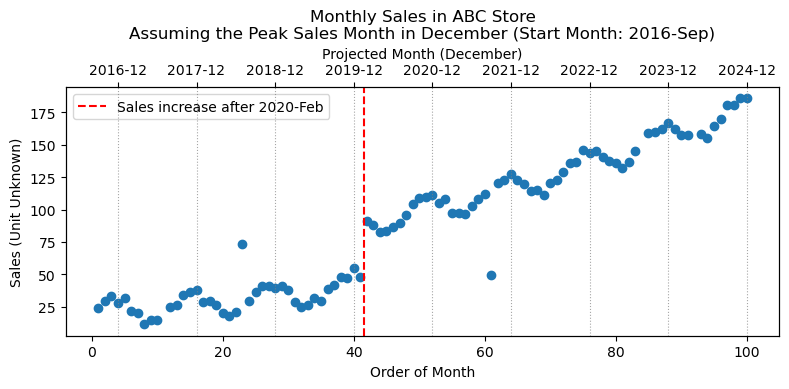

In [29]:
# ---------- remove obvious outliers ----------
# 1) remove zero or negative sales
df = df[df["sales"] > 0].copy()

# 2) remove statistical outliers using IQR
q1 = df["sales"].quantile(0.25)
q3 = df["sales"].quantile(0.75)
iqr = q3 - q1

# this factor (1.5) usually catches "the weird spikes" like the ones in your plot
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df = df[(df["sales"] >= lower_bound) & (df["sales"] <= upper_bound)].copy()


# ---------- Asigned Start Month as 2020-Oct ----------
# "month" is just a running number (1, 2, 3, ...) and we want to start at 2016-Sep to let the peak sale month of the year in December 
start_date = pd.Timestamp("2016-09-01")

# create a proper datetime column based on row position
df["date"] = [start_date + pd.DateOffset(months=int(m - 1)) for m in df["month"]]

# # now we use "date" as the true time index
df = df.sort_values("date").reset_index(drop=True)

# ---------- Overview of the raw data ----------
print(df.head())
print(df.tail())


# ---------- Quick plot of the data ----------
fig, ax1 = plt.subplots(figsize=(8, 4))

# Plot sales using the bottom x-axis (month)
ax1.plot(df.month, df.sales, 'o')
ax1.set_xlabel('Order of Month')
ax1.set_ylabel('Sales (Unit Unknown)')
ax1.set_title('Monthly Sales in ABC Store\nAssuming the Peak Sales Month in December (Start Month: 2016-Sep)')

# Create a secondary x-axis on top for date
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())

# Show only December dates on the upper x-axis
december_mask = df.date.dt.month == 12
dec_months = df.month[december_mask]
dec_labels = df.date[december_mask].dt.strftime('%Y-%m')

ax2.set_xticks(dec_months)
ax2.set_xticklabels(dec_labels)
ax2.set_xlabel('Projected Month (December)')
ax2.grid(axis='x', linestyle=':', color='gray', alpha=0.7)

# Add vertical reference line
ax1.axvline(x=41.5, color="red", linestyle="--", linewidth=1.5, label='Sales increase after 2020-Feb')
ax1.legend()

plt.tight_layout()
plt.show()

* Step-3: fit data with linear and seasonal functions
    * Fit with the whole data
    * Split data into two parts and fit separately

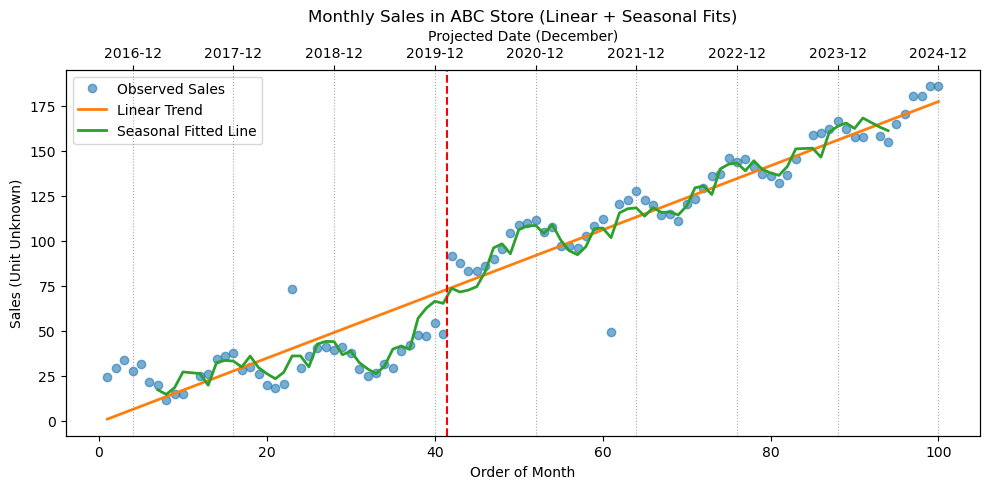

In [33]:
# ---------- Fit the whole data ----------

# Linear regression fit
df2 = df.copy()   # ✅ make a copy before modifying

X = df2["month"].values.reshape(-1, 1)
y = df2["sales"].values
linreg = LinearRegression()
linreg.fit(X, y)
df2["trend_linear"] = linreg.predict(X)

# 3. Seasonal decomposition (using statsmodels)
df2 = df2.set_index("date")
result = seasonal_decompose(df2["sales"], model="additive", period=12)
df2["seasonal_fit"] = result.trend + result.seasonal

# 4. Plot data + linear fit + seasonal fit with two x-axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# Bottom x-axis: month (numeric order)
ax1.plot(df2["month"], df2["sales"], "o", label="Observed Sales", alpha=0.6)
ax1.plot(df2["month"], df2["trend_linear"], "-", label="Linear Trend", linewidth=2)
ax1.plot(df2["month"], df2["seasonal_fit"], "-", label="Seasonal Fitted Line", linewidth=2)
ax1.axvline(x=41.5, color="red", linestyle="--", linewidth=1.5)

ax1.set_xlabel("Order of Month")
ax1.set_ylabel("Sales (Unit Unknown)")
ax1.set_title("Monthly Sales in ABC Store (Linear + Seasonal Fits)")

# Top x-axis: only December labels
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.grid(axis='x', linestyle=':', color='gray', alpha=0.7)

december_mask = df2.index.month == 12
dec_months = df2["month"][december_mask]
dec_labels = df2.index[december_mask].strftime("%Y-%m")

ax2.set_xticks(dec_months)
ax2.set_xticklabels(dec_labels)
ax2.set_xlabel("Projected Date (December)")

ax1.legend(loc="upper left")
plt.tight_layout()
plt.show()

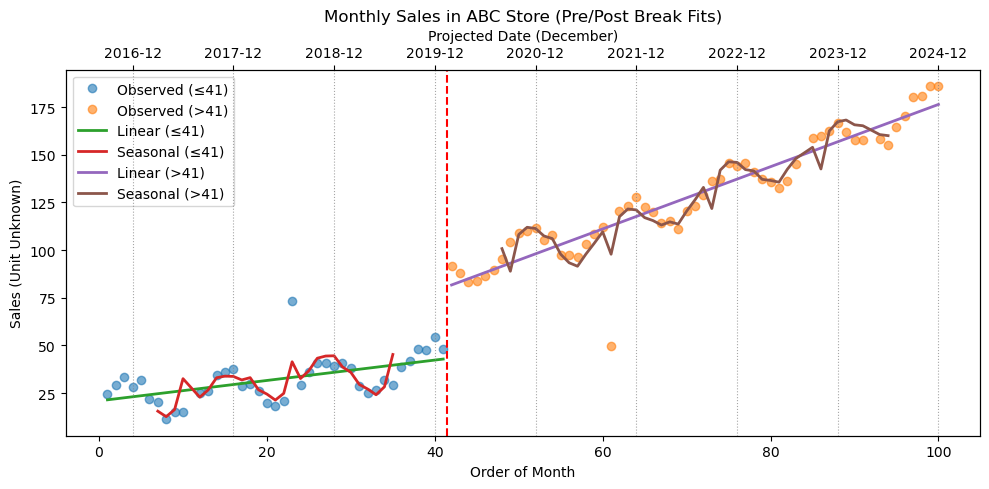

In [34]:
# ---------- Fit by separating data into two portions ----------

# start from the copied version
df2 = df.copy()

# make sure date is indexable later
df2 = df2.sort_values("date").reset_index(drop=True)

# ---------- 1. split into two parts ----------
break_month = 41.5
df2_part1 = df2[df2["month"] <= 41].copy()
df2_part2 = df2[df2["month"] > 41].copy()

# ---------- 2. fit linear + seasonal for part 1 ----------
# linear
X1 = df2_part1["month"].values.reshape(-1, 1)
y1 = df2_part1["sales"].values
lin1 = LinearRegression()
lin1.fit(X1, y1)
df2_part1["trend_linear"] = lin1.predict(X1)

# seasonal: need datetime index
df2_part1_idx = df2_part1.set_index("date")
res1 = seasonal_decompose(df2_part1_idx["sales"], model="additive", period=12)
df2_part1["seasonal_fit"] = (res1.trend + res1.seasonal).values

# ---------- 3. fit linear + seasonal for part 2 ----------
# linear
X2 = df2_part2["month"].values.reshape(-1, 1)
y2 = df2_part2["sales"].values
lin2 = LinearRegression()
lin2.fit(X2, y2)
df2_part2["trend_linear"] = lin2.predict(X2)

# seasonal
df2_part2_idx = df2_part2.set_index("date")
res2 = seasonal_decompose(df2_part2_idx["sales"], model="additive", period=12)
df2_part2["seasonal_fit"] = (res2.trend + res2.seasonal).values

# ---------- 4. plot together with dual x-axes ----------
fig, ax1 = plt.subplots(figsize=(10, 5))

# scatter original points (both parts)
ax1.plot(df2_part1["month"], df2_part1["sales"], "o", label="Observed (≤41)", alpha=0.6)
ax1.plot(df2_part2["month"], df2_part2["sales"], "o", label="Observed (>41)", alpha=0.6)

# fitted lines for part 1
ax1.plot(df2_part1["month"], df2_part1["trend_linear"], "-", label="Linear (≤41)", linewidth=2)
ax1.plot(df2_part1["month"], df2_part1["seasonal_fit"], "-", label="Seasonal (≤41)", linewidth=2)

# fitted lines for part 2
ax1.plot(df2_part2["month"], df2_part2["trend_linear"], "-", label="Linear (>41)", linewidth=2)
ax1.plot(df2_part2["month"], df2_part2["seasonal_fit"], "-", label="Seasonal (>41)", linewidth=2)

# vertical line to show jump
ax1.axvline(x=41.5, color="red", linestyle="--", linewidth=1.5)

ax1.set_xlabel("Order of Month")
ax1.set_ylabel("Sales (Unit Unknown)")
ax1.set_title("Monthly Sales in ABC Store (Pre/Post Break Fits)")

# ---------- top x-axis with December only ----------
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.grid(axis='x', linestyle=':', color='gray', alpha=0.7)

# Use the full df2 for December labels
december_mask = df2["date"].dt.month == 12
dec_months = df2["month"][december_mask]
dec_labels = df2["date"][december_mask].dt.strftime("%Y-%m")

ax2.set_xticks(dec_months)
ax2.set_xticklabels(dec_labels)
ax2.set_xlabel("Projected Date (December)")

ax1.legend(loc="upper left")
plt.tight_layout()
plt.show()

* Step-4: predictive results
    * To better reflect the true sales for 2025 and 2026, I only use data between 2020-Feb and 2024-Dec to train and make prediction
    * Procedure:
      * Cretae a few features
      *  

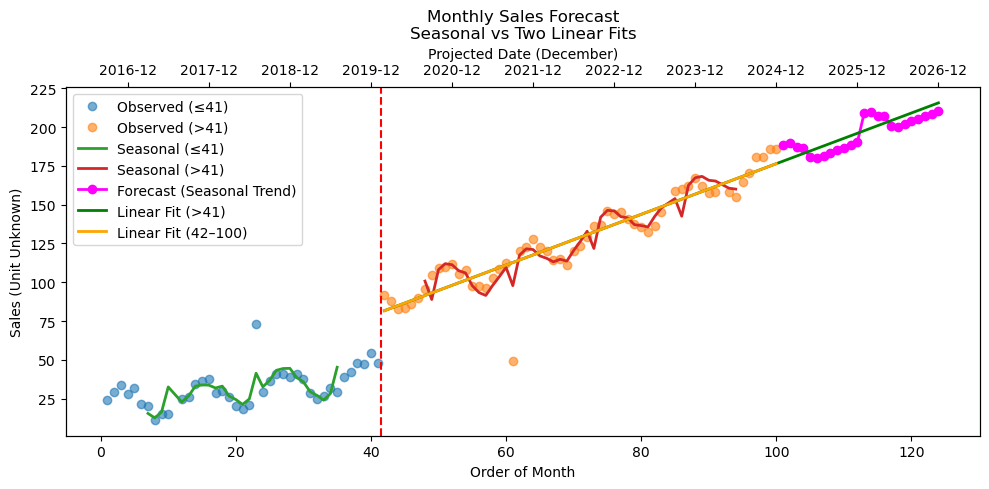

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# We'll base this on df2_part2 (post-jump)
df_post = df2_part2.copy()
period = 12  # monthly seasonality

# ---------------------------------------------------------
# TARGET: forecast until 2026-12
# ---------------------------------------------------------
last_date = df_post["date"].max()
target_end = pd.Timestamp("2026-12-01")
future_steps = (target_end.year - last_date.year) * 12 + (target_end.month - last_date.month)
future_steps = max(future_steps, 1)

last_month = df_post["month"].max()

# ---------------------------------------------------------
# A. LINEAR FIT #1: data > 41 (post-jump)
# ---------------------------------------------------------
x_post = df_post["month"].values
y_post = df_post["sales"].values
lin_slope1, lin_intercept1 = np.polyfit(x_post, y_post, 1)

x_fit1 = np.arange(42, last_month + future_steps + 1)
linear_fit1 = lin_slope1 * x_fit1 + lin_intercept1

# ---------------------------------------------------------
# B. LINEAR FIT #2: data between 42 and 100 months
# ---------------------------------------------------------
mask_42_100 = (df2["month"] >= 42) & (df2["month"] <= 100)
x_42_100 = df2.loc[mask_42_100, "month"].values
y_42_100 = df2.loc[mask_42_100, "sales"].values
lin_slope2, lin_intercept2 = np.polyfit(x_42_100, y_42_100, 1)

x_fit2 = np.arange(42, 100 + 1)
linear_fit2 = lin_slope2 * x_fit2 + lin_intercept2

# ---------------------------------------------------------
# C. SEASONAL FORECAST (clean NaNs in seasonal part)
# ---------------------------------------------------------
trend_vals = df_post["trend_linear"].values

# raw seasonal (may contain NaN at tail)
raw_seasonal = (df_post["seasonal_fit"] - df_post["trend_linear"]).copy()

# 1) forward-fill + back-fill to remove NaNs in the seasonal component
seasonal_vals = pd.Series(raw_seasonal).ffill().bfill().values

# 2) trend extrapolation
slope = (trend_vals[-1] - trend_vals[0]) / (len(trend_vals) - 1)
trend_forecast = trend_vals[-1] + slope * np.arange(1, future_steps + 1)

# 3) take the LAST FULL CLEAN CYCLE
last_clean_cycle = seasonal_vals[-period:]  # now guaranteed no NaNs

# 4) repeat it
seasonal_forecast = np.tile(last_clean_cycle, int(np.ceil(future_steps / period)))[:future_steps]

# 5) combine
forecast_sales = trend_forecast + seasonal_forecast

future_df_seasonal = pd.DataFrame({
    "month": np.arange(last_month + 1, last_month + future_steps + 1),
    "sales": forecast_sales
})
future_df_seasonal["date"] = [
    last_date + pd.DateOffset(months=i)
    for i in range(1, future_steps + 1)
]

# ---------------------------------------------------------
# D. PLOT EVERYTHING
# ---------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(10, 5))

# historical
ax1.plot(df2_part1["month"], df2_part1["sales"], "o", label="Observed (≤41)", alpha=0.6)
ax1.plot(df2_part2["month"], df2_part2["sales"], "o", label="Observed (>41)", alpha=0.6)
ax1.plot(df2_part1["month"], df2_part1["seasonal_fit"], "-", label="Seasonal (≤41)", linewidth=2)
ax1.plot(df2_part2["month"], df2_part2["seasonal_fit"], "-", label="Seasonal (>41)", linewidth=2)

# seasonal forecast (magenta)
ax1.plot(
    future_df_seasonal["month"],
    future_df_seasonal["sales"],
    "o-",
    color="magenta",
    linewidth=2,
    label="Forecast (Seasonal Trend)",
)

# linear fit #1 (green, only >41)
ax1.plot(
    x_fit1,
    linear_fit1,
    "-",
    color="green",
    linewidth=2,
    label="Linear Fit (>41)",
)

# linear fit #2 (orange, 42–100)
ax1.plot(
    x_fit2,
    linear_fit2,
    "-",
    color="orange",
    linewidth=2,
    label="Linear Fit (42–100)",
)

# vertical split
ax1.axvline(x=41.5, color="red", linestyle="--", linewidth=1.5)

ax1.set_xlabel("Order of Month")
ax1.set_ylabel("Sales (Unit Unknown)")
ax1.set_title("Monthly Sales Forecast\nSeasonal vs Two Linear Fits")

# ---------- Top x-axis (December labels) ----------
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())

december_mask = df2["date"].dt.month == 12
dec_months = list(df2["month"][december_mask])
dec_labels = list(df2["date"][december_mask].dt.strftime("%Y-%m"))

future_dec = future_df_seasonal[future_df_seasonal["date"].dt.month == 12]
if not future_dec.empty:
    dec_months.extend(future_dec["month"].tolist())
    dec_labels.extend(future_dec["date"].dt.strftime("%Y-%m").tolist())

ax2.set_xticks(dec_months)
ax2.set_xticklabels(dec_labels)
ax2.set_xlabel("Projected Date (December)")

ax1.legend(loc="upper left")
plt.tight_layout()
plt.show()


In [48]:
future_df_seasonal

,month,sales,date
0,101.0,188.603503,2025-01-01
1,102.0,189.563309,2025-02-01
2,103.0,187.117459,2025-03-01
3,104.0,186.675832,2025-04-01
4,105.0,180.470185,2025-05-01
5,106.0,179.965259,2025-06-01
6,107.0,181.656400,2025-07-01
7,108.0,183.347542,2025-08-01
8,109.0,185.038683,2025-09-01
9,110.0,186.729824,2025-10-01
